In [97]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [98]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data

## Load data

In [99]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [100]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [101]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [102]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [103]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [104]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [105]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        # TODO: masking
        # TODO: norm loss
        logits = self.decoder(encoding)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
)


In [106]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [107]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            X_hat = model.forward(X)

            batch_loss = loss(X, X_hat)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())

            if batch_idx % 10 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}: {batch_loss}")
                
    return train_loss_statistics

In [108]:
train_loss_statistics = train(train_loader, loss_fn, optimizer, model, epochs=20)

batch #0: 0.5011796951293945
batch #10: 0.26340946555137634
batch #20: 0.218366339802742
batch #30: 0.20963707566261292
batch #40: 0.20843321084976196
batch #50: 0.20732799172401428
batch #60: 0.20467562973499298
batch #70: 0.20297440886497498
batch #80: 0.2050096094608307
batch #90: 0.20396947860717773
batch #100: 0.19541361927986145
batch #110: 0.1972867250442505
batch #120: 0.18902716040611267
batch #130: 0.19047759473323822
batch #140: 0.192020446062088
batch #150: 0.18834829330444336
batch #160: 0.18828193843364716
batch #170: 0.18900376558303833
batch #180: 0.18659038841724396
batch #190: 0.18221710622310638
batch #200: 0.1791027933359146
batch #210: 0.17805258929729462
batch #220: 0.1730870008468628
batch #230: 0.17430230975151062
batch #240: 0.1715063452720642
batch #250: 0.1688026636838913
batch #260: 0.16741624474525452
batch #270: 0.16433003544807434
batch #280: 0.16355422139167786
batch #290: 0.15865477919578552
batch #300: 0.15641552209854126
batch #310: 0.1541030555963516

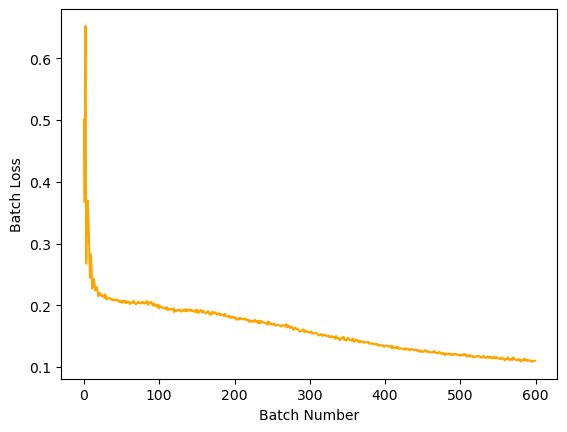

In [109]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange')
plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.show()

## Generating Image Samples

In [115]:
test_images_batch = next(iter(test_loader))[0]

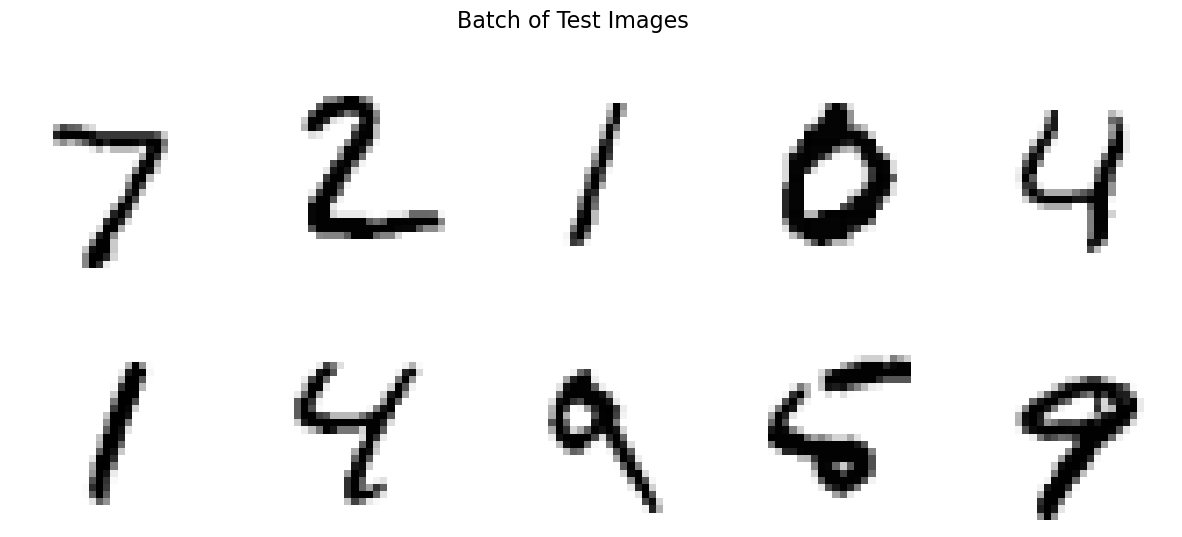

In [126]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images_batch[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Batch of Test Images', fontsize=16)
plt.show()

In [130]:
reconstructed_test_imgs = model.forward(torch.flatten(test_images_batch, start_dim=1).to("mps"))

In [133]:
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)

In [136]:
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

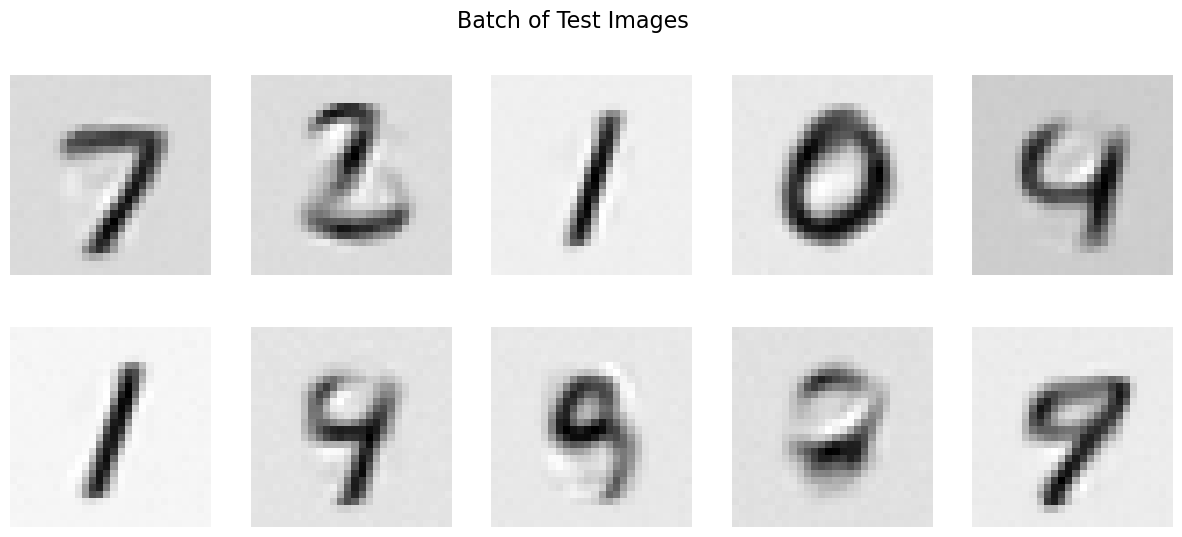

In [139]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_test_imgs[i]* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Batch of Test Images', fontsize=16)
plt.show()